In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
import joblib
import pickle
#from kaggle.competitions import nflrush
import tqdm
import re
from string import punctuation
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [15,10]

In [2]:
train = pd.read_csv('../input/nfl-big-data-bowl-2020/train.csv', dtype={'WindSpeed': 'object'})

## Feature Engineering

In [3]:
#https://www.kaggle.com/prashantkikani/nfl-starter-lgb-feature-engg
train['DefendersInTheBox_vs_Distance'] = train['DefendersInTheBox'] / train['Distance']

#cat feat
cat_features = []
for col in train.columns:
    if train[col].dtype =='object':
        cat_features.append((col, len(train[col].unique())))

#stadium type
def clean_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.lower()
    txt = ''.join([c for c in txt if c not in punctuation])
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    txt = txt.replace('outside', 'outdoor')
    txt = txt.replace('outdor', 'outdoor')
    txt = txt.replace('outddors', 'outdoor')
    txt = txt.replace('outdoors', 'outdoor')
    txt = txt.replace('oudoor', 'outdoor')
    txt = txt.replace('indoors', 'indoor')
    txt = txt.replace('ourdoor', 'outdoor')
    txt = txt.replace('retractable', 'rtr.')
    return txt

train['StadiumType'] = train['StadiumType'].apply(clean_StadiumType)
                                                  
def transform_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    if 'outdoor' in txt or 'open' in txt:
        return 1
    if 'indoor' in txt or 'closed' in txt:
        return 0
    
    return np.nan    
                                                  
train['StadiumType'] = train['StadiumType'].apply(transform_StadiumType)         
                                                  
#https://www.kaggle.com/c/nfl-big-data-bowl-2020/discussion/112681#latest-649087
Turf = {'Field Turf':'Artificial', 'A-Turf Titan':'Artificial', 'Grass':'Natural', 'UBU Sports Speed S5-M':'Artificial', 
        'Artificial':'Artificial', 'DD GrassMaster':'Artificial', 'Natural Grass':'Natural', 
        'UBU Speed Series-S5-M':'Artificial', 'FieldTurf':'Artificial', 'FieldTurf 360':'Artificial', 'Natural grass':'Natural', 'grass':'Natural', 
        'Natural':'Natural', 'Artifical':'Artificial', 'FieldTurf360':'Artificial', 'Naturall Grass':'Natural', 'Field turf':'Artificial', 
        'SISGrass':'Artificial', 'Twenty-Four/Seven Turf':'Artificial', 'natural grass':'Natural'} 

train['Turf'] = train['Turf'].map(Turf)
train['Turf'] = train['Turf'] == 'Natural'     
                                                  
#possession team fix different abr
                                                                                                                                                                                                             
map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
for abb in train['PossessionTeam'].unique():
    map_abbr[abb] = abb    
                                                  
train['PossessionTeam'] = train['PossessionTeam'].map(map_abbr)
train['HomeTeamAbbr'] = train['HomeTeamAbbr'].map(map_abbr)
train['VisitorTeamAbbr'] = train['VisitorTeamAbbr'].map(map_abbr)  
                                                  
train['HomePossesion'] = train['PossessionTeam'] == train['HomeTeamAbbr']    
                                                  
train['Field_eq_Possession'] = train['FieldPosition'] == train['PossessionTeam']
train['HomeField'] = train['FieldPosition'] == train['HomeTeamAbbr']
                                                  
off_form = train['OffenseFormation'].unique()
train['OffenseFormation'].value_counts()          
                                                  
train = pd.concat([train.drop(['OffenseFormation'], axis=1), pd.get_dummies(train['OffenseFormation'], prefix='Formation')], axis=1)
dummy_col = train.columns    
                                                  
#game clock
train['GameClock'].value_counts()
                                                  
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans                 
                                                  
train['GameClock'] = train['GameClock'].apply(strtoseconds)                                                  
                                                  
#sns.distplot(train['GameClock'])        
                                                  
#player height
                                                  
train['PlayerHeight'] = train['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
                                                  
train['PlayerBMI'] = 703*(train['PlayerWeight']/(train['PlayerHeight'])**2)
                                                  

In [5]:
#time handoff & player birthdate     

train['TimeHandoff'] = pd.to_datetime(train['TimeHandoff'])
train['TimeSnap'] = pd.to_datetime(train['TimeSnap'])
                                                  
train['TimeDelta'] = (train['TimeHandoff'] - train['TimeSnap']).dt.total_seconds()

train['PlayerBirthDate'] = pd.to_datetime(train['PlayerBirthDate'])
                                                  
seconds_in_year = 60*60*24*365.25
train['PlayerAge'] = (train['TimeHandoff'].dt.date - train['PlayerBirthDate'].dt.date).dt.total_seconds()/seconds_in_year 
                                                  

In [6]:
train = train.drop(['TimeHandoff', 'TimeSnap', 'PlayerBirthDate'], axis=1)     
                                                  
def str_to_float(txt):
    try:
        return float(txt)
    except:
        return -1      

#play direction                                                  
train['PlayDirection'].value_counts()     
train['PlayDirection'] = train['PlayDirection'].apply(lambda x: x.strip() == 'right')   
                                                  

#team home                                                  
train['Team'] = train['Team'].apply(lambda x: x.strip()=='home')                                                  
                                                  
#game weather
indoor = "indoor"
train['GameWeather'] = train['GameWeather'].apply(lambda x: x.lower().replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly').replace('clear and sunny', 'sunny and clear').replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)

#    climate controlled or indoor => 3, sunny or sun => 2, clear => 1, cloudy => -1, rain => -2, snow => -3, others => 0
#    partly => multiply by 0.5
                                                  
def map_weather(txt):
    ans = 1
    if pd.isna(txt):
        return 0
    if 'partly' in txt:
        ans*=0.5
    if 'climate controlled' in txt or 'indoor' in txt:
        return ans*3
    if 'sunny' in txt or 'sun' in txt:
        return ans*2
    if 'clear' in txt:
        return ans
    if 'cloudy' in txt:
        return -ans
    if 'rain' in txt or 'rainy' in txt:
        return -2*ans
    if 'snow' in txt:
        return -3*ans
    return 0
                                                  
train['GameWeather'] = train['GameWeather'].apply(map_weather)
                                                  
#Who's rusher
train['IsRusher'] = train['NflId'] == train['NflIdRusher']
train.drop(['NflId', 'NflIdRusher'], axis=1, inplace=True)    
                                                  
#playdirection - orientation
train['X'] = train.apply(lambda row: row['X'] if row['PlayDirection'] else 120-row['X'], axis=1)
#from https://www.kaggle.com/scirpus/hybrid-gp-and-nn
def new_orientation(angle, play_direction):
    if play_direction == 0:
        new_angle = 360.0 - angle
        if new_angle == 360.0:
            new_angle = 0.0
        return new_angle
    else:
        return angle
    
train['Orientation'] = train.apply(lambda row: new_orientation(row['Orientation'], row['PlayDirection']), axis=1)
train['Dir'] = train.apply(lambda row: new_orientation(row['Dir'], row['PlayDirection']), axis=1)
  
#yards left to endzone                                                  
train['YardsLeft'] = train.apply(lambda row: 100-row['YardLine'] if row['HomeField'] else row['YardLine'], axis=1)
train['YardsLeft'] = train.apply(lambda row: row['YardsLeft'] if row['PlayDirection'] else 100-row['YardsLeft'], axis=1)

#Clearly: Yards<=YardsLeft and YardsLeft-100<=Yards, thus we are going to drop those wrong lines.    
                                                  
train.drop(train.index[(train['YardsLeft']<train['Yards']) | (train['YardsLeft']-100>train['Yards'])], inplace=True)

#jersey nb to position
def convert_jn_to_position(df):
        jn = df['JerseyNumber']
        if jn < 10:
            df['QB'] = 1
            df['KP'] = 1
        elif jn >= 10 and jn < 20:
            df['QB'] = 1
            df['WR'] = 1
            df['KP'] = 1
        elif jn >= 20 and jn < 40:
            df['RB'] = 1
            df['DB'] = 1
        elif jn >= 40 and jn < 50:
            df['RB'] = 1
            df['LB'] = 1
            df['DB'] = 1
            df['TE'] = 1
        elif jn >= 50 and jn < 60:
            df['OL'] = 1
            df['DL'] = 1
            df['LB'] = 1
        elif jn >= 60 and jn < 80:
            df['OL'] = 1
            df['DL'] = 1
        elif jn >= 80 and jn < 90:
            df['WR'] = 1
            df['TE'] = 1
        elif jn >= 90 and jn < 100:
            df['DL'] = 1
            df['LB'] = 1

        return df

l = ['QB', 'KP', 'WR', 'RB', 'DB', 'LB', 'DB', 'TE', 'OL', 'DL']
d = dict.fromkeys(l, 0)
train = train.assign(**d).apply(convert_jn_to_position, axis=1)    

In [22]:
train.to_csv('../input/nfl-big-data-bowl-2020/train_processed.csv.zip')

# Baseline model

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import *
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import model_selection
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, LinearRegression
from sklearn import datasets, linear_model
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.distributions import uniform

In [4]:
data = pd.read_csv('../input/nfl-big-data-bowl-2020/train_processed.csv.zip')

In [5]:
data.columns

Index(['Unnamed: 0', 'GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis',
       'Orientation', 'Dir', 'DisplayName', 'JerseyNumber', 'Season',
       'YardLine', 'Quarter', 'GameClock', 'PossessionTeam', 'Down',
       'Distance', 'FieldPosition', 'HomeScoreBeforePlay',
       'VisitorScoreBeforePlay', 'OffensePersonnel', 'DefendersInTheBox',
       'DefensePersonnel', 'PlayDirection', 'Yards', 'PlayerHeight',
       'PlayerWeight', 'PlayerCollegeName', 'Position', 'HomeTeamAbbr',
       'VisitorTeamAbbr', 'Week', 'Stadium', 'Location', 'StadiumType', 'Turf',
       'GameWeather', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection',
       'DefendersInTheBox_vs_Distance', 'HomePossesion', 'Field_eq_Possession',
       'HomeField', 'Formation_ACE', 'Formation_EMPTY', 'Formation_I_FORM',
       'Formation_JUMBO', 'Formation_PISTOL', 'Formation_SHOTGUN',
       'Formation_SINGLEBACK', 'Formation_WILDCAT', 'PlayerBMI', 'TimeDelta',
       'PlayerAge', 'IsRusher', 'YardsLeft', 'QB', 

In [6]:
data = data.sort_values(by=['PlayId', 'Team', 'IsRusher', 'JerseyNumber']).reset_index()

In [7]:
data.drop(['GameId', 'PlayId', 'index', 'IsRusher', 'Team'], axis=1, inplace=True)

In [8]:
cat_features = []
for col in data.columns:
    if data[col].dtype =='object':
        cat_features.append(col)
        
data = data.drop(cat_features, axis=1)
print(cat_features)

['DisplayName', 'PossessionTeam', 'FieldPosition', 'OffensePersonnel', 'DefensePersonnel', 'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'Stadium', 'Location', 'WindSpeed', 'WindDirection']


In [9]:
data.fillna(-999, inplace=True)

In [10]:
players_col = []
for col in data.columns:
    if data[col][:22].std()!=0:
        players_col.append(col)

In [11]:
X = np.array(data[players_col]).reshape(-1, len(players_col)*22)

In [12]:
play_col = data.drop(players_col+['Yards'], axis=1).columns
X_play_col = np.zeros(shape=(X.shape[0], len(play_col)))
for i, col in enumerate(play_col):
    X_play_col[:, i] = data[col][::22]

In [13]:
X = np.concatenate([X, X_play_col], axis=1)
y = data['Yards'][::22].values
#y = np.zeros(shape=(X.shape[0], 199))
#for i,yard in enumerate(train['Yards'][::22]):
#    y[i, yard+99:] = np.ones(shape=(1, 100-yard))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=93)

In [15]:
kfold = model_selection.KFold(n_splits=10)

In [25]:
grid_dict = {
    "Linear Regression" : GridSearchCV(LinearRegression(),
                    param_grid={},
                    cv=kfold
                    ),
    
    "Ridge" : GridSearchCV(Pipeline([('scaler',  StandardScaler()),
                        ('ridge', Ridge(alpha=1))]),
                    param_grid={
                                'ridge__alpha': [0.1,1,10,100, 1000, 10000, 100000]
                    },
                    cv=kfold
                    ),
    "Decision Tree": GridSearchCV(DecisionTreeRegressor(max_depth=1, min_samples_leaf=1, max_features=1, ),
                    param_grid={
                                'max_depth': [3,9,17, 23, 35,49],
                                'min_samples_leaf': [1,5,10,15,20,30,40,60],
                                'max_features': ['auto', 'sqrt', 'log2']
                    },
                    cv=kfold
                    ),
    "Random Forest": GridSearchCV(RandomForestRegressor(max_depth=1, min_samples_leaf=1, max_features=1, n_estimators=1 ),
                param_grid={
                            'max_depth': [3, 9, 17, 23],
                            'min_samples_leaf': [5,10,15,25,50],
                            'max_features': ['auto', 'sqrt', 'log2'],
                            'n_estimators': [5,25,50,100,250],
                            'criterion': ['gini', 'entropy']
                },
                cv=kfold
                )

}

In [26]:
import os

for model_name, grid in grid_dict.items():
    file_path = f'./{model_name.replace(" ","")}.grid'
    print(model_name)
    if os.path.exists(file_path):
        print("     Skipping")
        continue
    grid.fit(X_train, y_train)
    joblib.dump(grid, file_path)

Linear Regression
Ridge
Decision Tree


KeyboardInterrupt: 

In [21]:
from IPython.display import display, HTML

for model_name in grid_dict:
    grid = joblib.load(f'./{model_name.replace(" ","")}.grid')
    
    df = pd.DataFrame(grid.cv_results_["params"])
    df.insert(0, "Std Score", grid.cv_results_["std_test_score"])
    df.insert(0, "Mean Score", grid.cv_results_["mean_test_score"])
    
    display(df.sort_values("Mean Score", ascending=False).style.set_caption(model_name))
    print("Best estimator test score:",r2_score(y_test, grid.best_estimator_.predict(X_test)))


,Mean Score,Std Score
0,-1.4249e+18,4.09928e+18


Best estimator test score: -1.515970530947257e+24


,Mean Score,Std Score,ridge__alpha
9,0.0349508,0.00307689,10000
8,0.0349043,0.00482697,1000
7,0.032509,0.00542904,100
6,0.0305471,0.0055311,10
5,0.0291182,0.00552819,1
4,0.028748,0.005546,0.1
10,0.0193431,0.00138231,100000
0,-0.790987,0.763515,-100
1,-21.8668,65.5163,-10
2,-2183.19,6549.65,-1


Best estimator test score: -65550939.69189004


,Mean Score,Std Score,max_depth,max_features,min_samples_leaf
6,0.0357389,0.00585652,3,auto,40
7,0.0357369,0.00581117,3,auto,60
5,0.0344274,0.00667975,3,auto,30
4,0.03358,0.00692251,3,auto,20
2,0.0335425,0.00690189,3,auto,10
3,0.0335425,0.00690189,3,auto,15
1,0.0334475,0.00704245,3,auto,5
0,0.0245271,0.0103702,3,auto,1
11,0.0170302,0.0061093,3,sqrt,15
10,0.0166732,0.00642508,3,sqrt,10


Best estimator test score: -0.19426068260805907


In [0]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=5, n_repeats=5)

models = []

for tr_idx, vl_idx in rkf.split(X_train, y_train):
    
    x_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
    x_vl, y_vl = X_train[vl_idx], y_train[vl_idx]
    
    model = train_model(x_tr, y_tr, x_vl, y_vl)
    models.append(model)

In [0]:
pd.unique(train2["StadiumType"])

array(['Outdoor', 'Outdoors', 'Indoors', 'Retractable Roof', 'Indoor',
       'Retr. Roof-Closed', 'Open', nan, 'Indoor, Open Roof',
       'Retr. Roof - Closed', 'Outddors', 'Dome', 'Domed, closed',
       'Indoor, Roof Closed', 'Retr. Roof Closed',
       'Outdoor Retr Roof-Open', 'Closed Dome', 'Oudoor', 'Ourdoor',
       'Dome, closed', 'Retr. Roof-Open', 'Heinz Field', 'Outdor',
       'Retr. Roof - Open', 'Domed, Open', 'Domed, open', 'Cloudy',
       'Bowl', 'Outside', 'Domed'], dtype=object)

(array([[9.4600e+02, 7.2600e+02, 1.5840e+03, 1.5620e+03, 3.0360e+03,
         1.9360e+03, 2.6620e+03, 2.5300e+03, 2.0240e+03, 1.8700e+03],
        [2.8072e+04, 2.6158e+04, 3.0008e+04, 3.5662e+04, 6.5340e+04,
         4.5870e+04, 5.1106e+04, 4.9522e+04, 4.6662e+04, 4.2922e+04],
        [5.9400e+02, 1.9580e+03, 4.4000e+03, 5.5440e+03, 1.0604e+04,
         6.7320e+03, 6.8200e+03, 7.2600e+03, 6.7760e+03, 5.6980e+03],
        [8.8000e+01, 2.6400e+02, 3.0800e+02, 6.3800e+02, 1.7380e+03,
         1.3860e+03, 1.2100e+03, 1.1000e+03, 1.3200e+03, 9.2400e+02],
        [0.0000e+00, 8.8000e+01, 4.4000e+01, 6.6000e+01, 1.9800e+02,
         1.5400e+02, 4.4000e+02, 5.2800e+02, 3.7400e+02, 1.5400e+02],
        [4.4000e+01, 2.2000e+01, 0.0000e+00, 0.0000e+00, 1.1000e+02,
         6.6000e+01, 1.7600e+02, 1.3200e+02, 1.3200e+02, 3.3000e+02],
        [2.2000e+01, 0.0000e+00, 4.4000e+01, 4.4000e+01, 4.4000e+01,
         4.4000e+01, 4.4000e+01, 1.1000e+02, 8.8000e+01, 6.6000e+01],
        [0.0000e+00, 2.2000

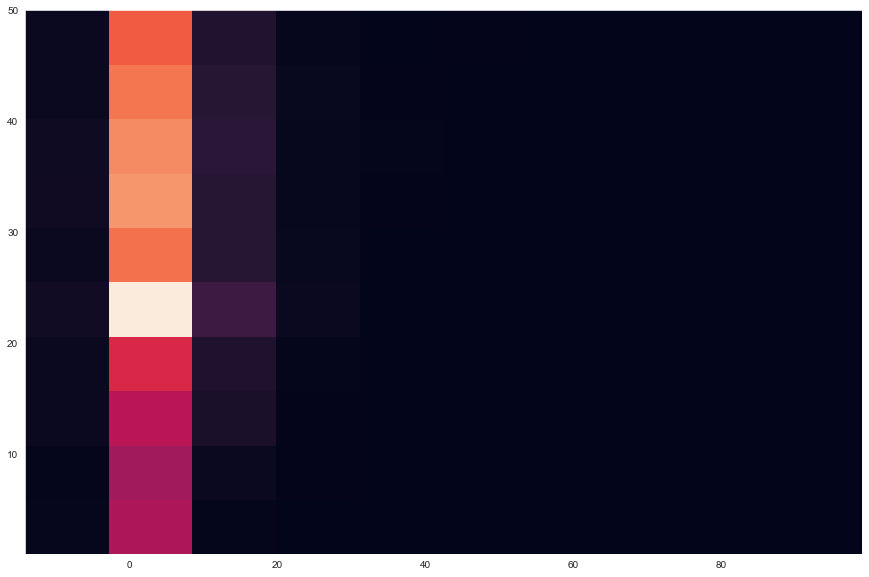

In [51]:
plt.hist2d(data['Yards'], data["YardLine"])

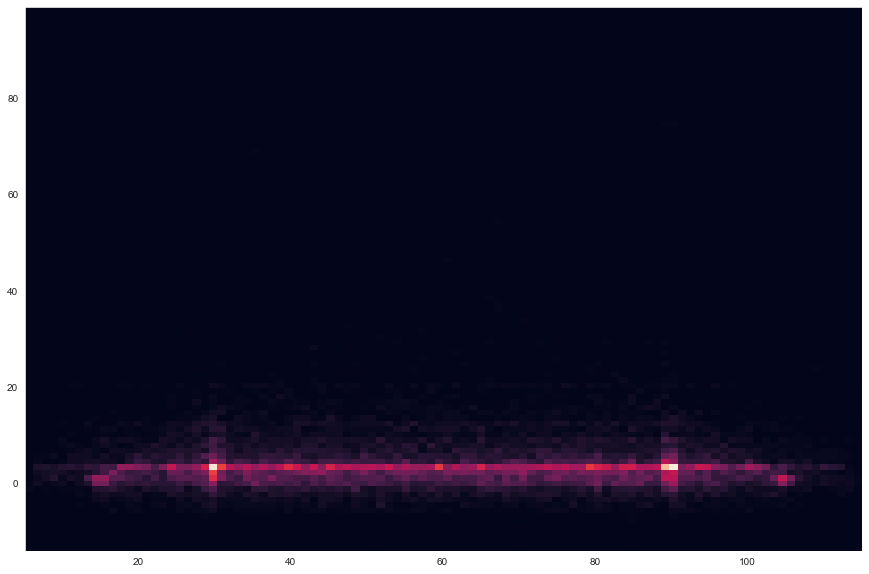

In [61]:
train2['IsRusher'] = train2['NflId'] == train2['NflIdRusher']

a1,b1,b2,f = plt.hist2d(train2["X"][train2["IsRusher"]], train2["Yards"][train2["IsRusher"]], bins=100)

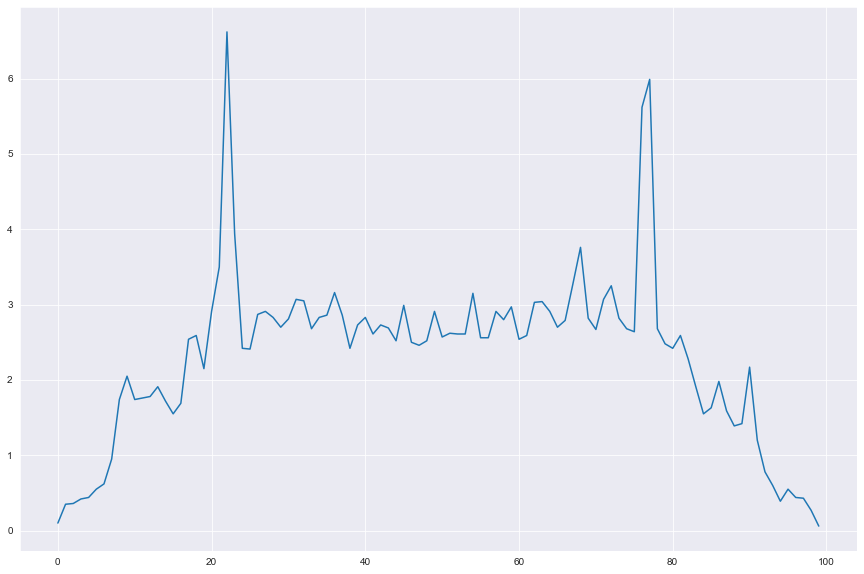

In [66]:
plt.plot(np.sum(a1, axis=1))

# End

If you reached this far please comment and upvote this kernel, feel free to make improvements on the kernel and please share if you found anything useful!